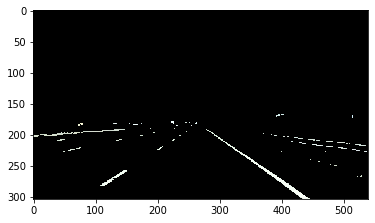

In [2]:
# Read in the image
image = mpimg.imread('test01.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# Define color selection criteria
###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
blue_threshold = 200
green_threshold = 200
red_threshold = 200
######

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image                 
plt.imshow(color_select)

In [8]:
# Read in the image and print some stats
image = mpimg.imread('test01.jpg')
print('This image is: ', type(image),'with dimensions:', image.shape)

# Pull out the x and y sizes and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
region_select = np.copy(image)

# Define a triangle region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz 
left_bottom = [50, 300]
right_bottom = [500, 300]
apex = [250, 150]

# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))


# Color pixels red which are inside the region of interest
region_thresholds = np.logical_and(np.logical_not(thresholds), region_thresholds)
region_select[np.logical_not(region_thresholds)] = [0, 0, 0]

# Display the image
#check matplotlib.pyplot.plot (https://matplotlib.org/api/pyplot_api.html#module-matplotlib.pyplot)
#tip:plt.plot([0], [539], 'bo')
plt.imshow(region_select)

This image is:  <class 'numpy.ndarray'> with dimensions: (304, 540, 3)


NameError: name 'thresholds' is not defined

In [ ]:
def do_segment(img):
    segmentator = cv2.ximgproc.segmentation.createGraphSegmentation(sigma=0.5, k=300, min_size=5000)
    segment = segmentator.processImage(img)
    seg_image = np.zeros(img.shape, np.uint8)
    for i in range(np.max(segment)):
      # 將第 i 個分割的座標取出
      y, x = np.where(segment == i)
      # 隨機產生顏色
      color = [random.randint(0, 255), random.randint(0, 255),random.randint(0, 255)]
      # 設定第 i 個分割區的顏色
      for xi, yi in zip(x, y):
        seg_image[yi, xi] = color
    # 將原始圖片與分割區顏色合併
    result = cv2.addWeighted(img, 0.3, seg_image, 0.7, 0)
    plt.imshow(result)
    plt.show()
    return result

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import cv2

In [2]:
def getEdge(img, kernel_size=(5, 5), low_thr=50, high_thr=150):
    # Define a kernel size and apply Gaussian smoothing
    blured = cv2.GaussianBlur(img, kernel_size, 0)

    edges = cv2.Canny(blured, low_thr, high_thr)

    return edges

def getLines(pts_img_like, threshold=1, min_line_length=20, max_line_gap=5):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1           # pixel resolution: 1 pixel
    theta = np.pi/180 # angle resolution: 1 degree
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    return lines

def getLineLength(line):
    return np.sqrt((line[:,0] - line[:,2])**2 + (line[:,1] - line[:,3])**2)

def distanceToLine(line, pt):
    st = line[:,0:2]
    end = line[:,2:]
    vec0 = end - st
    vec1 = pt - st
    area = vec0[:,0]*vec1[:,1] - vec0[:,1]*vec1[:,0]
    length = area / getLineLength(line)
    return length

In [3]:
def calHoughSpace(line, center):
    theta = np.arctan((line[:,3]-line[:,1])/(line[:,2]-line[:,0]))
    r = distanceToLine(line, center)
    return np.stack((theta, r), axis = 1)


In [4]:
class RoadEstimator:
    def __init__(self, imgSize):
        self.ScatterScale = 0.5        # Map -1.57~1.57 to 0~resolution
        self.ScatterResolution = 100   # theta * Scale * Resoultion
        self.ScatterDecay = 0.9
        self.houghScatter = np.zeros((self.ScatterResolution, 3), dtype=np.float)
        self.imgSize = imgSize
        self.center = (self.imgSize[0]//2, 300)
    
    def HoughPolarToXYLine(self, houghPoint):
        center = self.center
        th_angle = (houghPoint[0]-self.ScatterResolution/2)/self.ScatterResolution/self.ScatterScale
        l = houghPoint[2]/np.sin(th_angle)
        lowerPoint = (int(center[0]+l), center[1])
        upperPoint = (int(center[0]+l-center[1]/np.tan(th_angle)), 0)
        return lowerPoint, upperPoint
    
    def calMainWeight(self, lines, houghPoints):
        # factors
        lineLength = getLineLength(lines)
        lineDisX = abs(lines[:,0]+lines[:,2])/2 - self.imgSize[0]/2
        lineDisY = self.imgSize[1] - abs(lines[:,1]+lines[:,3])
        lineDis = np.sqrt(lineDisX**2 + lineDisY**2)
        
        # Calculate weight for determining main line
        #factorA = houghPoints[:, 0] * houghPoints[:, 1] / np.mean(houghPoints[:, 1])
        factorB = lineLength / np.mean(lineLength)
        factorC = lineDisY / np.mean(lineDisY)
        factorD = -(lineDis / np.mean(lineDis))
        
        weight = houghPoints[:, 0] * (factorB+factorC+factorD) * 10
        return weight
    
    def calHoughScaledArray(self, lines):
        houghPoints = calHoughSpace(lines, self.center)
        
        # Filter nan values
        m = np.logical_not(np.isnan(houghPoints[:,1]))
        houghPoints = houghPoints[m]
        
        weight = self.calMainWeight(lines, houghPoints)
        
        # change into array size
        x = (houghPoints[:, 0] * self.ScatterScale*self.ScatterResolution).astype(int)
        
        # Clip into array size
        x = x.clip(-self.ScatterResolution//2, self.ScatterResolution//2-1)
        
        # parameters reset
        self.houghScatter[:, 1] = 0    # real r
        self.houghScatter[:, 2] = 0    # number of r samples
        for (dx, dw, dr) in zip(x, weight, houghPoints[:, 1]):
            self.houghScatter[dx+self.ScatterResolution//2, 0] += dw
            self.houghScatter[dx+self.ScatterResolution//2, 1] += dr
            self.houghScatter[dx+self.ScatterResolution//2, 2] += 1
        # samples = 0
        self.houghScatter[self.houghScatter[:, 2] <= 0.001, 2] = 1000000
        # average r
        self.houghScatter[:, 1] /= self.houghScatter[:, 2]
        
        # Filter minimux & maximum
        self.houghScatter[0, 0]=0
        self.houghScatter[-1, 0]=0
        mean = np.mean(self.houghScatter[:,0])
        
        # concate all coulumns -> [ theta, weight, real_r, number_of_r_samples]
        scaled = np.column_stack((np.arange(self.ScatterResolution, dtype=np.int16), 
                                  self.houghScatter[:,0] / mean, 
                                  self.houghScatter[:,1:]))
        # decay
        self.houghScatter[:,0] *= self.ScatterDecay
        print(scaled)
        return scaled
        
    """
    Input: Hought Scaled array with weight
    Output: True/False Array
    """
    def getMainRoadPoints(self, scaled):
        criteria = np.logical_and(np.absolute(scaled[:,1])>15, scaled[:,2]>0.001)
        points = scaled[criteria]
        return points
    
    def drawSummary(self, img, scaled, points, mainPoints, frameBound):
        for p in scaled:
            startP = (int( p[0]-50+width//2 ), 200)
            cv2.line(img, startP, (startP[0], int(200-int(abs(p[1])))), (0, 0, 255), 1)
            cv2.line(img, startP, (startP[0], int(200+int(abs(p[2])))), (0, 255, 0), 1)
            
            
        for p in points:
            cv2.circle(img, (int(p[0])-50+width//2, 200), 3, (0, 255, 255), 1)
            
        for p in mainPoints:
            cv2.circle(img, (int(p[0])-50+width//2, 200), 5, (255, 255, 0), 2)
        """
        # left max
        cv2.circle(img, (int(mainPoints[0,0])-50+width//2, 200), 5, (255, 255, 0), 2)
        # Left avr
        cv2.circle(img, (int(mainPoints[0,1])-50+width//2, 200) , 5, (255, 0, 0), 2)
        # Right max  
        cv2.circle(img, (int(mainPoints[1,0])-50+width//2, 200), 5, (255, 255, 0), 2)
        # Right avr
        cv2.circle(img, (int(mainPoints[1,1])-50+width//2, 200) , 5, (255, 0, 0), 2)
        """
        #cv2.line(img, frameBound[0][0], frameBound[0][1], (255, 255, 255), 4)
        #cv2.line(img, frameBound[1][0], frameBound[1][1], (0, 0, 0), 4)
        return img
    
    def analyzePoints(self, img, points):
        lefts = points[points[:,0]<self.ScatterResolution//2]
        rights = points[points[:,0]>self.ScatterResolution//2]
        leftBound = []
        rightBound = []
        mainPoint = []
        if(lefts.shape[0] > 0):
            leftMax = lefts[np.argmax(np.absolute(lefts), axis=0)[1]]
            mainPoint.append(leftMax)
            #mainPoint.append(np.mean(lefts, axis=0)[0])
            
            leftBound = self.HoughPolarToXYLine(leftMax)
            cv2.line(img, leftBound[0], leftBound[1], (255, 255, 255), 4)
            
        if(rights.shape[0] > 0):
            rightMax = rights[np.argmax(np.absolute(rights), axis=0)[1]]
            mainPoint.append(rightMax)
            #mainPoint.append(np.mean(rights, axis=0)[0])
            
            rightBound = self.HoughPolarToXYLine(rightMax)
            cv2.line(img, rightBound[0], rightBound[1], (0, 0, 0), 4)
            
        return (leftBound, rightBound), mainPoint

In [ ]:
# Read in and grayscale the image
"""
img = mpimg.imread('exit-ramp.jpg')
height = img.shape[0]
width = img.shape[1]
"""
cap = cv2.VideoCapture('highway_record4.mp4')

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
fps = cap.get(cv2.CAP_PROP_FPS)

roi_base = (0, height//2)
roi_size = (width, height*3//4)

roadFrame = RoadEstimator(imgSize=(width, height))
while(cap.isOpened()):
#for i in range(3):
    ret, frame = cap.read()
    #frame = img
    roi = np.zeros([height,width], dtype=np.uint8)
    roi[height*3//5:height*4//5,0:width] = 255
    
    img = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)
    roi=cv2.add(img, np.zeros(np.shape(frame), dtype=np.uint8), mask=roi)
    
    #for idx in range(3):
    idx = 1
    channel = roi[:,:,idx]
    channel = cv2.morphologyEx(channel, cv2.MORPH_OPEN, (3, 3))
    edges = getEdge(channel)
    
    lines = np.squeeze(getLines(edges, threshold=1, min_line_length=10), axis=1)

    name = 'edge'+str(idx)
    cv2.imshow(name,roi)
    
    line_image = np.copy(frame) #creating a blank to draw lines on
    
    for x1,y1,x2,y2 in lines:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),2)
    
    scaled = roadFrame.calHoughScaledArray(lines)
    points = roadFrame.getMainRoadPoints(scaled)
    frameBound, mainPoints = roadFrame.analyzePoints(line_image, points)
    line_image = roadFrame.drawSummary(line_image, scaled, points, mainPoints, frameBound)
        
    cv2.imshow('frame',line_image)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


[[ 0.00000000e+00 -0.00000000e+00  1.14146511e+02  4.00000000e+00]
 [ 1.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 2.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 3.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 4.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 5.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 6.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 7.00000000e+00  1.52219172e+02  5.40315633e+01  1.00000000e+00]
 [ 8.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 9.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 1.00000000e+01 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 1.10000000e+01 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 1.20000000e+01 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 1.30000000e+01 -0.00000000e+00  0.00000000e+00  1.00000000e+06]
 [ 1.40000000e+01 -0.00000000e+00  0.00000000e+00  1.00000000e

In [3]:
line = np.array([[100, 100, 200, 200]])
center = (500, 360)
theta = np.arctan((line[:,3]-line[:,1])/(line[:,2]-line[:,0]))
print(theta)

r = distanceToLine(line, center)
print(r)
leftMax = [theta, 0, r]

th_angle = theta
l = leftMax[2]/np.sin(th_angle)
lowerPoint = (int(center[0]+l), center[1])
upperPoint = (int(center[0]+l-center[1]/np.tan(th_angle)), 0)
print(lowerPoint)
print(upperPoint)

[0.78539816]
[-98.99494937]
(360, 360)
(0, 0)


In [ ]:
# Read in and grayscale the image
#img = mpimg.imread('exit-ramp.jpg')
cap = cv2.VideoCapture('highway_record4.mp4')

#color=[random.randint(0, 255), random.randint(0, 255),random.randint(0, 255)]
color=[0,255,0]
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
fps = cap.get(cv2.CAP_PROP_FPS)
roi_base = (0, height//2)
roi_size = (width, height*3//4)


ScatterScale = 0.5        # Map -1.57~1.57 to 0~resolution
ScatterResolution = 100   # theta * Scale * Resoultion
ScatterDecay = 0.9
houghScatter = np.zeros((ScatterResolution, 3), dtype=np.float)

def HoughPolarToXYLine(houghPoint, center):
    th_angle = (houghPoint[0]-ScatterResolution/2)/ScatterResolution/ScatterScale
    l = houghPoint[2]/np.sin(th_angle)
    lowerPoint = (int(center[0]+l), center[1])
    upperPoint = (int(center[0]+l-center[1]/np.tan(th_angle)), 0)
    return lowerPoint, upperPoint

while(cap.isOpened()):
    ret, frame = cap.read()
    
    roi = np.zeros([height,width], dtype=np.uint8)
    roi[height*3//5:height*4//5,0:width] = 255
    
    img = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)
    roi=cv2.add(img, np.zeros(np.shape(frame), dtype=np.uint8), mask=roi)
    
    lines = []
    #for idx in range(3):
    idx = 1
    channel = roi[:,:,idx]
    #if( idx == 0 ):
    channel = cv2.morphologyEx(channel, cv2.MORPH_OPEN, (3, 3))
    edges = getEdge(channel)
    ll = np.squeeze(getLines(edges, threshold=1, min_line_length=10), axis=1)
    lines.append(ll)
    name = 'edge'+str(idx)
    cv2.imshow(name,roi)
        
    line_image = np.copy(frame) #creating a blank to draw lines on
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),color,2)
    
    for line in lines:
        center = (width//2, 300)
        houghPoints = calHoughSpace(line, center)
        lineLength = getLineLength(line)
        # Filter nan values
        m = np.logical_not(np.isnan(houghPoints[:,1]))
        houghPoints = houghPoints[m]
        lineDisX = abs(line[:,0]+line[:,2])/2 - width/2
        lineDisY = height - abs(line[:,1]+line[:,3])
        lineDis = np.sqrt(lineDisX**2 + lineDisY**2)
        
        # Calculate weight = r * theta
        #factorA = houghPoints[:, 0] * houghPoints[:, 1] / np.mean(houghPoints[:, 1])
        factorB = lineLength / np.mean(lineLength)
        factorC = lineDisY / np.mean(lineDisY)
        factorD = -(lineDis / np.mean(lineDis))
        weight = houghPoints[:, 0] * (factorB+factorC+factorD) * 10
        x = (houghPoints[:, 0] * ScatterScale*ScatterResolution).astype(int)
        
        # Clip into array size
        x = x.clip(-ScatterResolution//2, ScatterResolution//2-1)
        # Weighted add
        houghScatter[:, 1] = 0
        houghScatter[:, 2] = 0
        for (dx, dw, dr) in zip(x, weight, houghPoints[:, 1]):
            houghScatter[dx+ScatterResolution//2, 0] += dw
            houghScatter[dx+ScatterResolution//2, 1] += dr
            houghScatter[dx+ScatterResolution//2, 2] += 1
        houghScatter[houghScatter[:, 2] <= 0.001, 2] = 1000000
        houghScatter[:, 1] /= houghScatter[:, 2]
        
        # Filter minimux & maximum
        houghScatter[0, 0]=0
        houghScatter[-1, 0]=0
        mean = np.mean(houghScatter[:,0])
        scaled = np.column_stack((np.arange(ScatterResolution, dtype=np.int16), 
                                  houghScatter[:,0] / mean, 
                                  houghScatter[:,1:]))
        
        print(scaled)
        # Calculate outstanding ones
        crtiria = np.logical_and(np.absolute(scaled[:,1])>15, scaled[:,2]>0.001)
        points = scaled[crtiria]
        #print(houghScatter)
        #houghScatter *= ScatterDecay
        houghScatter[:,0:2] *= ScatterDecay
        
        i=0
        for p in houghScatter:
            cv2.line(line_image, (i-50+width//2, 200), (i-50+width//2, int(200-abs(p[0]))), (0, 0, 255), 1)
            cv2.line(line_image, (i-50+width//2, 200), (i-50+width//2, int(200+abs(p[1]))), (0, 255, 0), 1)
            i += 1

        for p in points:
            cv2.circle(line_image, (int(p[0])-50+width//2, 200), 3, (0, 255, 255), 1)
            
        lefts = points[points[:,0]<ScatterResolution//2]
        rights = points[points[:,0]>ScatterResolution//2]
        
        if(lefts.shape[0] > 0):
            leftMax  = lefts[np.argmax(np.absolute(lefts), axis=0)[1]]
            leftAvr  = np.mean(lefts, axis=0)[0]
            print(leftMax)
            cv2.circle(line_image, (int(leftMax[0]) -50+width//2, 200), 5, (255, 255, 0), 2)
            cv2.circle(line_image, (int(leftAvr)-50+width//2, 200) , 5, (255, 0, 0), 2)
            
            (upperPoint, lowerPoint) = HoughPolarToXYLine(leftMax, center)
            cv2.line(line_image, upperPoint, lowerPoint, (255, 255, 255), 4)
            
        if(rights.shape[0] > 0):
            rightMax = rights[np.argmax(np.absolute(rights), axis=0)[1]]
            rightAvr = np.mean(rights, axis=0)[0]
            
            cv2.circle(line_image, (int(rightMax[0]) -50+width//2, 200), 5, (255, 255, 0), 2)
            cv2.circle(line_image, (int(rightAvr)-50+width//2, 200) , 5, (255, 0, 0), 2)
            
            (upperPoint, lowerPoint) = HoughPolarToXYLine(rightMax, center)
            cv2.line(line_image, upperPoint, lowerPoint, (0, 0, 0), 4)
        
    cv2.line(line_image,(width//2,0),(width//2,300),(0, 255, 255),2)
    cv2.imshow('frame',line_image)
    if cv2.waitKey(100) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#plt.imshow(img)
#plt.show()

#plt.axis([-1, 1, 0, 100])
#plt.show()
"""
m = (line[:,1] - line[:,3])/(line[:,0] - line[:,2])
b = (line[:,0]*line[:,3] - line[:,2]*line[:,1])/(line[:,0]-line[:,2])
w = np.sqrt((line[:,0] - line[:,2])**2 + (line[:,1] - line[:,3])**2)
info.append((m,b,w))
"""
#print(info)
#plt.plot(m, b, 'b+')
#plt.show()
#for x1,y1,x2,y2 in line:
    
#edges = getEdge(img)
#lines = getLines(img, threshold=1, min_line_length=10)
#plt.imshow(edges)
#plt.show()
#plt.imshow(combo)
#plt.show()